# Running different algorithms

### Importing libraries

In [19]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from os import listdir
from sklearn.cross_validation import train_test_split 


### Defining path to data

In [20]:
path = 'C:/Users/izaou/Documents/ML_Project-master/clean_data/'

In [21]:
print(listdir(path))

['complete_gradboost_GENDER.csv', 'complete_logreg_GENDER.csv', 'complete_randforest_GENDER.csv', 'Parameters', 'targets.csv', 'targets_flat.csv', 'test.csv', 'train.csv', 'train_age_only_filled.csv']


### Loading train data

In [22]:
train = pd.read_csv(path + 'train.csv', index_col='user_id')
targets = pd.read_csv(path + 'targets_flat.csv', dtype={"user_id":object, "country_destination":object}, index_col=['user_id'])
targets_train = targets[targets.country_destination.notnull()].values.reshape(-1,)

In [23]:
targets_train

array(['NDF', 'NDF', 'US', ..., 'NDF', 'NDF', 'NDF'], dtype=object)

## Predicting classes by taking out age and gender

### Defining the train dataset

In [24]:

to_drop= ['age', 'gender__MALE', 'gender__FEMALE', 'gender__OTHER','language__no','signup_method__google','first_affiliate_tracked__local ops','affiliate_provider__naver','affiliate_provider__baidu','affiliate_provider__yandex','language__id','language__hu','affiliate_provider__wayn','language__da','language__tr','language__th','language__fi','date_account_created_hour_sin','language__is','language__is','date_account_created_hour_cos','language__ca','language__cs','affiliate_provider__daum','language__hr','signup_method__weibo']

df1_train = train.drop(to_drop, axis=1)

In [25]:
train_age=pd.read_csv(path +'train_age_only_filled.csv', index_col='user_id')
train_gender=pd.read_csv(path +'complete_gradboost_GENDER.csv', index_col='user_id')
train_age=train_age.astype(np.float)
train_gender=train_gender.astype(np.float)
df_train = pd.concat([df1_train, train_age,train_gender], axis=1, join_axes=[df1_train.index])

### Importing libraries

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb

import timeit
from sklearn.metrics import accuracy_score

from sklearn.cross_validation import train_test_split #for splitting data into train and test
from sklearn.cross_validation import *


In [27]:
X_train, X_test, y_train, y_test=train_test_split(df_train,targets_train,test_size=0.2,random_state=1)

### Defining classifiers

### Fitting data and prediction for random forest

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [29]:
def fun_cross_val_score(my_MODEL, algo, cv=20):
    scores = cross_val_score(my_MODEL, X_train, y_train, cv=cv)
    print("Accuracy %s: %0.8f (+/- %0.2f)" % (algo ,scores.mean(), scores.std() * 2))
    return

In [30]:
models=dict()
models['Random Forest 1']=RandomForestClassifier()

models['Random Forest 2'] = RandomForestClassifier(
    n_estimators=21, min_samples_split=10, max_leaf_nodes=10, max_depth=50, random_state=0)

models['Random Forest 3'] = RandomForestClassifier(
    n_estimators=20, min_samples_split=10, max_leaf_nodes=12, max_depth=12, random_state=0)

In [31]:
X_train, X_test, y_train, y_test=train_test_split(df_train,targets_train,test_size=0.2,random_state=1)
for key, value in models.items():
    fun_cross_val_score(value, key)

Accuracy Random Forest 3: 0.5830 (+/- 0.00)
Accuracy Random Forest 2: 0.5830 (+/- 0.00)
Accuracy Random Forest 1: 0.5623 (+/- 0.01)


# Optimisation with gridsearch

In [32]:

from sklearn.model_selection import GridSearchCV

In [33]:
#parameters for RF, GB, XGB
param_grid_RF = {'n_estimators' : range(10,30,10),
                 'min_samples_split' : range(2, 5),
                 'max_leaf_nodes' : range(8, 10),
                 'max_depth' : range(10, 14),
                'criterion':['gini', 'entropy']}

param_grid_GB = {'n_estimators':range(10, 101, 50),
                 'min_samples_split':range(2,8),
                 'max_depth':range(2,10)}

param_grid_DT = {'criterion':['entropy', 'gini'],
                 'splitter':['random', 'best'],
                 'min_samples_split':range(2, 15),  
                 'min_samples_leaf':range(2,15),
                 'max_leaf_nodes':range(10, 20)}


param_grid_XGB = {'learning_rate':range(0,05),
                  'max_depth':range(8,10),
                  'n_estimators': range(10,300,50)}                  

In [34]:
#grid search for Random Forest
gs = GridSearchCV(RandomForestClassifier(random_state=42),
                  param_grid=param_grid_RF,cv=5)
gs.fit(X_train, y_train)
results = gs.cv_results_
paramsRF = gs.best_params_
print paramsRF

{'min_samples_split': 2, 'max_leaf_nodes': 9, 'criterion': 'gini', 'max_depth': 10, 'n_estimators': 10}


In [38]:
#RF optimized
pred_rf=[]

for i in range(0,3):
    X_train, X_test, y_train, y_test=train_test_split(df_train,targets_train,test_size=0.2)

    rf=RandomForestClassifier(n_estimators=10, min_samples_split=2, max_leaf_nodes=9, criterion='entropy',max_depth=10)
    mod_rf=rf.fit(X_train,y_train)
    p_rf=mod_rf.predict(X_test)
    pred_rf.append(accuracy_score(y_test,p_rf))

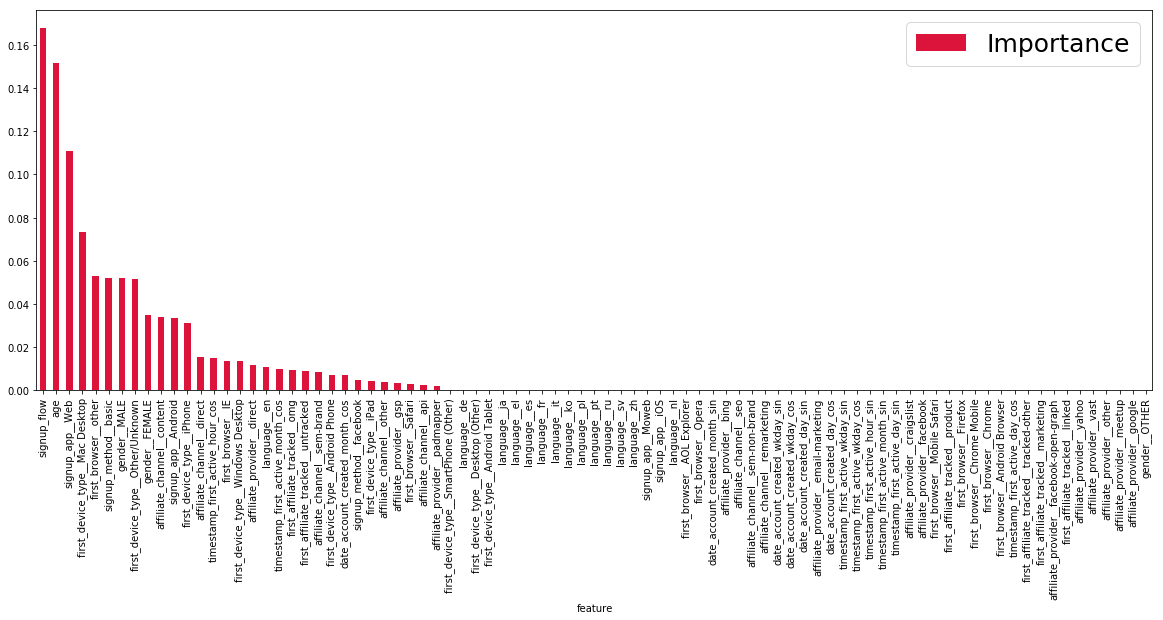

In [39]:
features = pd.DataFrame()
features['feature'] = df_train.columns
features['Importance'] = mod_rf.feature_importances_
features.sort_values(by=['Importance'], ascending=False, inplace=True)
features.set_index('feature', inplace=True)

features.plot(kind='bar', figsize=(20, 7), color='crimson')
plt.legend(['Importance'],prop=({'size':25}))
plt.show()